# Image matching with Siamese networks
## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader
import utilities as utils 
from siameseDataloader import readDataFolder, dataSplits, TripletDataset
from siameseModel import MobileNetTriplet

In [2]:
import os
config = utils.load_config()
datadir = os.path.join('data','tiny-imagenet-200-copy','train')#config['DATASET']['root']
numclasses = config['DATASET']['numclasses']
sameprob = config['DATASET']['sameprob']
im_size = config['DATASET']['im_size']
emb_size=config['MODEL']['embsize']

seed = config['seed']
np.random.seed(seed)

device = config['TRAIN']['device']

## Dataset

In [3]:
dataset = readDataFolder(datadir,numclasses)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: data\tiny-imagenet-200-copy\train


In [4]:
train_split,val_split,test_split = dataSplits(dataset,0.8,0.2,0)

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(im_size+4),
    transforms.RandomCrop(im_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0.3),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])
test_transforms = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])

train_dataset = TripletDataset(train_split,train_transforms)
val_dataset = TripletDataset(val_split,test_transforms)
test_dataset = TripletDataset(test_split,test_transforms)

datasets = {'train':train_dataset,'val':val_dataset,'test':test_dataset}

In [6]:
#dataloaders
dataloaders = {
    'train': DataLoader(train_dataset,shuffle=True,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'val': DataLoader(val_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'test': DataLoader(test_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize'])
}

In [7]:
for i,data in enumerate(dataloaders['train']):
    print(data[0].shape)
    break

torch.Size([32, 3, 32, 32])


## Model

In [14]:
model = MobileNetTriplet(config['MODEL']['distance'],embsize=emb_size,pretrained=config['MODEL']['pretrained'])

Using cache found in C:\Users\Emilija/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [9]:
for param in model.parameters():
    param.requires_grad = True

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

4431828


In [11]:
data = train_dataset[400]
out = model(data[0].reshape(1,3,im_size,im_size),data[1].reshape(1,3,im_size,im_size),data[2].reshape(1,3,im_size,im_size))
print(out)
#print(criterion(out,data[2]))


(tensor([[ 0.0671, -0.1113,  0.0613, -0.0598,  0.0864,  0.2344,  0.0288,  0.0850,
         -0.1108,  0.0588,  0.0656,  0.0956,  0.1192,  0.1203,  0.0472,  0.0315,
          0.0266,  0.1176,  0.0608, -0.1547]], grad_fn=<AddmmBackward0>), tensor([[ 0.0648, -0.1174,  0.0603, -0.0589,  0.0839,  0.2338,  0.0263,  0.0824,
         -0.1131,  0.0615,  0.0627,  0.0960,  0.1219,  0.1171,  0.0466,  0.0290,
          0.0303,  0.1132,  0.0636, -0.1523]], grad_fn=<AddmmBackward0>), tensor([[ 0.0673, -0.1120,  0.0625, -0.0596,  0.0865,  0.2323,  0.0253,  0.0836,
         -0.1071,  0.0575,  0.0658,  0.0984,  0.1180,  0.1185,  0.0506,  0.0289,
          0.0263,  0.1131,  0.0600, -0.1522]], grad_fn=<AddmmBackward0>))


## Train

In [12]:
#model.to('cpu')
#model.load_state_dict(model1)

In [13]:
criterion = torch.nn.TripletMarginWithDistanceLoss(margin = config['TRAIN']['lossmargin'], distance_function=model.distance)
#config['TRAIN']['lr'] =0.0005
optimizer = optim.Adam(model.parameters(),lr = config['TRAIN']['lr'],weight_decay=0.03)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:

model = model.to(device)

In [15]:
loss_history ={'train':[],'val':[]}
minloss=10000


In [16]:
best_model = model.state_dict().copy() 

In [17]:

for epoch in range(config['TRAIN']['numepochs']):
    for mode in ['train','val']:
        loss_epoch=0
        count=0
        for i,(img1,img2,img3) in enumerate(dataloaders[mode]):
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            
            if mode=='train':
                model.train()
                
                optimizer.zero_grad()
                out1,out2,out3 = model(img1,img2,img3)
                loss = criterion(out1,out2,out3)
                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                with torch.no_grad():
                    out1,out2,out3 = model(img1,img2,img3)
                loss = criterion(out1,out2,out3)
            
            # track total loss
            loss_epoch = loss_epoch+loss
            count = count + img1.shape[0]
            
        #scheduler.step()
        
        loss_history[mode].append(loss_epoch.item()/count)
    print('Epoch: {},\t train loss:{:.5},\t val loss:{:.5}'.format(epoch,loss_history['train'][-1],loss_history['val'][-1]))

    if (loss_history['val'][-1] < minloss):
        minloss = loss_history['val'][-1]
        best_model = model.state_dict().copy()
            
            

Epoch: 0,	 train loss:0.038819,	 val loss:0.032922
Epoch: 1,	 train loss:0.030971,	 val loss:0.029884
Epoch: 2,	 train loss:0.028365,	 val loss:0.029322
Epoch: 3,	 train loss:0.026906,	 val loss:0.02971
Epoch: 4,	 train loss:0.026626,	 val loss:0.027626
Epoch: 5,	 train loss:0.025487,	 val loss:0.028355
Epoch: 6,	 train loss:0.02447,	 val loss:0.026417
Epoch: 7,	 train loss:0.024221,	 val loss:0.026369
Epoch: 8,	 train loss:0.023905,	 val loss:0.026249
Epoch: 9,	 train loss:0.023694,	 val loss:0.0259
Epoch: 10,	 train loss:0.023069,	 val loss:0.02673
Epoch: 11,	 train loss:0.023136,	 val loss:0.025964
Epoch: 12,	 train loss:0.022258,	 val loss:0.027267
Epoch: 13,	 train loss:0.023169,	 val loss:0.027505


KeyboardInterrupt: 

In [18]:
model.load_state_dict(best_model)

<All keys matched successfully>

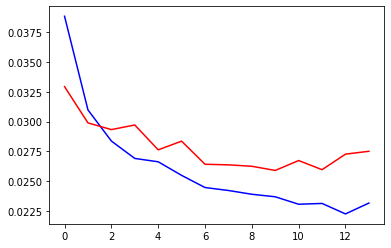

In [19]:
plt.figure()
plt.plot(loss_history['train'],'b-')
plt.plot(loss_history['val'],'r-')

## Train acc

In [ ]:
model.eval()
model=model.to(device)
#threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=10)
threshs = [config['TRAIN']['lossmargin']/2]
#threshs=[0.5]
accs = []
sensitivity = []
specificity = []
f1=[]


for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['train']):
        img1=img1.to(device)
        img2=img2.to(device)
        label=label.to(device)
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T*1.,(out>=thresh)*1.)
        conf[1,0] += torch.matmul(label.T*1.,(out<thresh)*1.)
        conf[0,1] += torch.matmul((1-label).T*1.,(out>=thresh)*1.)
        conf[0,0] += torch.matmul((1-label).T*1.,(out<thresh)*1.)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())

In [ ]:
print(accs)
print(f1)

## Val

In [ ]:
loss_epoch = 0
count=0
for i,(img1,img2,label) in enumerate(dataloaders['val']):
    img1 = img1.to(device)
    img2=img2.to(device)
    label = label.to(device)
    with torch.no_grad():
        out = model(img1,img2)
        loss = criterion(out,label)

    # track total loss
    loss_epoch = loss_epoch+loss
    count = count + len(label)
print('Validation loss: {}'.format(loss_epoch.item()/count))

In [ ]:
# Visualise
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    example = val_dataset[i]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,im_size,im_size).to(device),example[1].reshape(1,3,im_size,im_size).to(device))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

In [ ]:
#threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=11)
threshs = [config['TRAIN']['lossmargin']/2]
#threshs = [0.5]
#threshs = np.linspace(start=0,stop=1,num=11)
accs=[]
sensitivity = []
specificity = []
f1=[]

num=0
for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['val']):
        img1=img1.to(device)
        img2=img2.to(device)
        label=label.to(device)
        
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T*1.,(out>=thresh)*1.)
        conf[1,0] += torch.matmul(label.T*1.,(out<thresh)*1.)
        conf[0,1] += torch.matmul((1-label).T*1.,(out>=thresh)*1.)
        conf[0,0] += torch.matmul((1-label).T*1.,(out<thresh)*1.)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())
    
    print(num)
    num += 1

In [ ]:
print(accs)
print(f1)

In [ ]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

## Test

In [ ]:
loss_epoch=0
count=0
for i,(img1,img2,label) in enumerate(dataloaders['test']):
    with torch.no_grad():
        out = model(img1,img2)
        loss = criterion(out,label)

    # track total loss
    loss_epoch = loss_epoch+loss
    count = count + len(label)
print('Test loss: {}'.format(loss_epoch.item()/count))
    

In [ ]:
# Visualise
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    example = test_dataset[i]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,64,64),example[1].reshape(1,3,64,64))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

In [ ]:
threshs = [1]
accs = []
sensitivity = []
specificity = []
f1=[]


for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['test']):
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T,(out>=thresh)*1)
        conf[1,0] += torch.matmul(label.T,(out<thresh)*1)
        conf[0,1] += torch.matmul((1-label).T,(out>=thresh)*1)
        conf[0,0] += torch.matmul((1-label).T,(out<thresh)*1)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())
    break

In [ ]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

## Save model

In [20]:
#torch.save(model.state_dict(),config['MODEL']['modelpath'])
model = model.to('cpu')
torch.save(model.state_dict(),"models\\mobilenet_triplet_state_dict_50cls.pkl")

# Exctract embeddings

In [18]:
model.load_state_dict(torch.load("models\\mobilenet_triplet_state_dict_50cls.pkl"))

In [20]:
model = model.to(device)

In [25]:
train_embs = []
train_labels = []
val_embs = []
val_labels = []

In [26]:
for i,(img1,img2,img3) in enumerate(dataloaders['train']):
    img1 = img1.to(device)
    img2 = img2.to(device)
    img3 = img3.to(device)
    with torch.no_grad():
        out1 = model.getEmb(img1,img2)
        out2 = model.getEmb(img1,img3)

    train_embs+=out1.tolist()
    train_embs+=out2.tolist()
    train_labels+=np.ones((img1.shape[0],)).tolist()
    train_labels+=np.zeros((img1.shape[0],)).tolist()

In [27]:
for i,(img1,img2,img3) in enumerate(dataloaders['val']):
    img1 = img1.to(device)
    img2 = img2.to(device)
    img3 = img3.to(device)
    with torch.no_grad():
        out1 = model.getEmb(img1,img2)
        out2 = model.getEmb(img1,img3)

    val_embs+=out1.tolist()
    val_embs+=out2.tolist()
    val_labels+=np.ones((img1.shape[0],)).tolist()
    val_labels+=np.zeros((img1.shape[0],)).tolist()

In [28]:
torch.save((train_embs,train_labels),'trainembs_triplet.pkl')
torch.save((val_embs,val_labels),'valembs_triplet.pkl')